In [80]:
import pandas as pd
import numpy as np

#import Libraries for Graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Naive Bayes and KNN models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# get Training and Testing sets
train_set = pd.read_csv('./input/train.csv')
test_set = pd.read_csv('./input/test.csv')

combine = [train_set, test_set]

# Store our passenger ID for easy access
PassengerId = test_set['PassengerId']

In [81]:
#drop columns not needed
train_set = train_set.drop(["Ticket", "Cabin"], axis=1)
test_set = test_set.drop(["Ticket", "Cabin"], axis=1)
combine = [train_set, test_set]

# change sex to binary
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
train_set.fillna(train_set.median(), inplace=True)
test_set.fillna(test_set.median(), inplace=True)

#Fill empty/null values for embarked
freq_port = train_set.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
#fill empty/null values for fare
test_set['Fare'].fillna(test_set['Fare'].dropna().median(), inplace=True)    

#update combine
combine = [train_set, test_set]

In [82]:
#change fare to integers so it can be used in model easier
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [83]:
#change embarked to numbers so it can be used in the model
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [84]:
#dropping name and passengerid
train_set = train_set.drop(['Name','PassengerId'], axis=1)
test_set = test_set.drop(['Name','PassengerId'], axis=1)

In [85]:
train_set.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,0,0
1,1,1,1,38.0,1,0,3,1
2,1,3,1,26.0,0,0,1,0
3,1,1,1,35.0,1,0,3,0
4,0,3,0,35.0,0,0,1,0


In [86]:
#dropping unnecessary columns
trainX = train_set.drop(["Survived", "SibSp", "Parch", "Embarked"], axis=1).values
trainY = train_set["Survived"].values

In [88]:
trainSplitX, testSplitX, trainSplitY, testSplitY = train_test_split(trainX, trainY, test_size = 0.33, random_state = 45)
trainSplitX.shape, trainSplitY.shape, testSplitX.shape, testSplitY.shape

((596, 4), (596,), (295, 4), (295,))

In [89]:
#Naive Bayes with Gaussian model
gaussianModel = GaussianNB()
gaussianModel.fit(trainSplitX, trainSplitY)
predictedY = gaussianModel.predict(testSplitX)


print("Accuracy: ", metrics.accuracy_score(testSplitY, predictedY))
print("Precision: ", metrics.precision_score(testSplitY, predictedY))
print("Recall: ", metrics.recall_score(testSplitY, predictedY))
print("F1 Score: ", metrics.f1_score(testSplitY, predictedY))

Accuracy:  0.7932203389830509
Precision:  0.6721311475409836
Recall:  0.7961165048543689
F1 Score:  0.7288888888888888


In [90]:
#use the default 5 fold validation
gaussianModel = GaussianNB()
gaussianModelCrossValidation = gaussianModel.fit(trainSplitX, trainSplitY)
scoreArray=['accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(gaussianModelCrossValidation, trainSplitX, trainSplitY, scoring=scoreArray)

In [91]:
listOfScores = list(scores.values())
result = [] 
for i in range(len(listOfScores)): 
   result.append(np.average(listOfScores[i])) 

def printResult(i, data):
    if (i == 0):
        print("Fit Time: ", data)
    elif (i == 1):
        print("Score Time: ", data)
    elif (i == 2):
        print("Accuracy: ", data)
    elif (i == 3):
        print("Precision: ", data)
    elif (i == 4):
        print("Recall: ", data)
    else:
        print("F1 Score: ", data)

#Print results obtained from 5 fold cross validation
for i in range(len(result)):
    printResult(i, result[i])

Fit Time:  0.0005002498626708984
Score Time:  0.00150146484375
Accuracy:  0.7415406162464986
Precision:  0.6584089191232048
Recall:  0.736790780141844
F1 Score:  0.695035595130162


In [106]:
#Task 2, Question 1 answer is in the PDF

#Task 2, Question 2. Implementation of KNN classification from scratch

from scipy.spatial import distance
from collections import Counter

class myNearestNeighbors():
    def setVariables(self, givenTrainX, givenTrainY):
        self.trainX = givenTrainX
        self.trainY = givenTrainY

    def yPrediction(self, givenTestX, k):
        predictionArray = []
        for row in givenTestX:
            label = self.nearestNeighbor(row, k)
            predictionArray.append(label)
            
        return predictionArray

    def nearestNeighbor(self, row, k):
        distanceArray = []
        for i in range(len(self.trainX)):
            distanceArray.append((i, distance.euclidean(row, self.trainX[i])))
        
        distanceArray = sorted(distanceArray, key=lambda x:x[1])[0:k]
        
        arrayOfKIndex = []
        for i in range(k):
            arrayOfKIndex.append(distanceArray[i][0])
            
        arrayOfKLabels = []
        for i in range(k):
            arrayOfKLabels.append(self.trainY[arrayOfKIndex[i]])
            
        countArray = Counter(arrayOfKLabels)
        
        return countArray.most_common()[0][0]
    
knnModel = myNearestNeighbors()
knnModel.setVariables(trainSplitX, trainSplitY)

k = 15
accuracyArray = []

for i in range(1, k):
    predictedY = knnModel.yPrediction(testSplitX, k)
    accuracyArray.append(metrics.accuracy_score(testSplitY, predictedY))
    
print(accuracyArray)

#I'm getting the same result for all of the k values
#the error has to be in my function nearestNeighbot but i'll be using the sklearn KNN for answering
#task 2 q3

[0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356, 0.752542372881356]


Optimal K @ 2 with accuracy of  0.7830508474576271


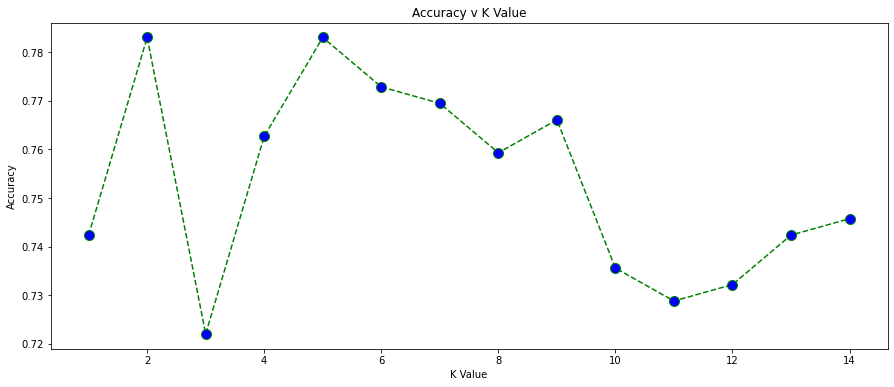

In [108]:
#KNN with titanic dataset
accuracySet = []
for i in range (1,15):
    kNN = KNeighborsClassifier(n_neighbors=i)
    kNN.fit(trainSplitX, trainSplitY)
    predictedKnnOfI = kNN.predict(testSplitX)
    accuracySet.append(metrics.accuracy_score(testSplitY, predictedKnnOfI))
    
plt.figure(figsize=(15, 6))
plt.plot(range(1, 15), accuracySet, color='green', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy v K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
print("Optimal K @", accuracySet.index(max(accuracySet))+1, "with accuracy of ", max(accuracySet))

In [ ]:
#task 2 Q3 in pdf